In [15]:
from streamlit_main import load_data

In [16]:
import matplotlib.pyplot as plt
import altair as at
import pandas as pd

In [21]:
data = load_data()
del data['_id']

In [22]:
data.head()

,lotCode,name,style,mapLink,percentAvailable,datetime,date
0,CD FS,Cone Deck Faculty/Staff,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022 20:45:37,11/21/2022
1,CD VS,Cone Deck Visitor,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022 20:45:37,11/21/2022
2,CRI,CRI Deck,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,0.98,11/21/2022 20:45:37,11/21/2022
3,ED1,East Deck 1,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022 20:45:37,11/21/2022
4,ED2/3,East Deck 2/3,None,None,0.95,11/21/2022 20:45:37,11/21/2022


In [23]:
data.datetime = pd.to_datetime(data['datetime'])

In [26]:
data = data.set_index('datetime')

In [27]:
data

,lotCode,name,style,mapLink,percentAvailable,date
datetime,,,,,,
2022-11-21 20:45:37,CD FS,Cone Deck Faculty/Staff,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022
2022-11-21 20:45:37,CD VS,Cone Deck Visitor,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022
2022-11-21 20:45:37,CRI,CRI Deck,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,0.98,11/21/2022
2022-11-21 20:45:37,ED1,East Deck 1,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,1.00,11/21/2022
2022-11-21 20:45:37,ED2/3,East Deck 2/3,None,None,0.95,11/21/2022
...,...,...,...,...,...,...
2022-11-25 11:45:41,NORTH,North Deck,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,0.98,11/25/2022
2022-11-25 11:45:41,SOUTH,South Village Deck,None,https://maps.charlotte.edu/#/?nav=pLdbs&ctr=35...,0.95,11/25/2022
2022-11-25 11:45:41,UDL,Union Deck Lower,None,None,1.00,11/25/2022


In [40]:
# Uptime checking
hourly = data.copy()
hourly.index = hourly.index.to_period('H')
hourly_counts = hourly.groupby('datetime').count()['percentAvailable']

TypeError: float() argument must be a string or a real number, not 'Period'

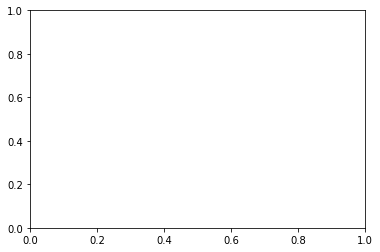

In [41]:
plt.plot(hourly_counts)